<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# Import python libraries 
import pystorms 
# Python Scientific Computing Stack
import numpy as np
import pandas as pd
# Plotting tools
import seaborn as sns
from matplotlib import pyplot as plt

In [14]:
# set seaborn figure preferences and colors
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("darkgrid")
colorpalette = sns.color_palette("colorblind")
colors_hex = colorpalette.as_hex()

In [17]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


|              | __Target depth__ | __Upper Depth Limit__ | __Lower Depth Limit__ | __Upper Depth Sublimit__ | __Lower Depth Sublimit__ |
|--------------|------|-------|------|------|------|
|North Basin 3 | 5.42 | 11.99 | 5.28 | 5.92 | 5.32 |
|North Basin 2 | 4.54 | 6.59  | 4.04 | 5.04 | 4.44 |
|North Basin 1 | 5.3  | 5.92  | 2.11 | 5.8  | 5.2  |
|Central Basin | 3.38 | 5.7   | 2.21 | 3.8  | 3.28 |
|South Basin   | 6.5  | 9.5   | 0.0  | 6.55 | 0.0  |

In [3]:
################################################################################
# Uncontrolled performance - control asset settings are set to all ones
################################################################################
env_uncontrolled_ones = pystorms.scenarios.delta()
done = False
actions = np.ones(5)
while not done:
    done = env_uncontrolled_ones.step(actions)
uncontrolled_perf_ones = sum(env_uncontrolled_ones.data_log["performance_measure"])

In [4]:
################################################################################
# Uncontrolled performance - control asset settings are set to all zeros
################################################################################
env_uncontrolled_zeros = pystorms.scenarios.delta()
done = False
actions = np.zeros(5)
while not done:
    done = env_uncontrolled_zeros.step(actions)
uncontrolled_perf_zeros = sum(env_uncontrolled_zeros.data_log["performance_measure"])

In [5]:
################################################################################
# Controller one:  Equal filling degree
################################################################################
def controller_one(state, settings):
    actions = np.ones(5)

    # (north3, north2, north1, central, south)
    target = [5.42, 4.54, 5.3, 3.38, 6.5]
    max_desired = [5.92, 5.04, 5.8, 3.8, 6.55]
    min_desired = [5.32, 4.44, 5.2, 3.28, 0]
    max_allowed = [11.99, 6.59, 5.92, 5.7, 9.5]
    min_allowed = [5.28, 4.04, 2.11, 2.21, 0]

    thismax = max_allowed
    #thismax = max_desired
    thismin = min_allowed
    #thismin = min_desired

    states = [state[2], state[1], state[0], state[4], state[5]]
    states_normal = [state - min for (state, min) in zip(states, thismin)]
    range = [max - min for (max, min) in zip(thismax, thismin)]
    #
    fd = [(state/state_max) for (state, state_max) in zip(states_normal, range)]
    fd_average = sum(fd)/len(fd)
    potential = [filldeg - fd_average for filldeg in fd]
    #
    for i, ptnl in enumerate(potential):
        if ptnl < -0.001:
            potential[i] = 0
        elif ptnl < 0.001:
            potential[i] = fd_average
    #
    sum_potential = sum(potential)
    if sum_potential > 0.0:
        potential_new = [ptnl / sum_potential for ptnl in potential]
    #
    new_settings = np.zeros(5)
    new_state = [trgt * ptnl for (trgt, ptnl) in zip(target, potential_new)]
    for i, st in enumerate(states):
        if st > 0.00:
            new_settings[i] = min(1.0, new_state[i]/target[i])

    delta = 0.1
    if state[3] > 3.38:
        new_settings[4] = min(1.0, new_settings[4] + delta)
    else:
        if settings[4] > new_settings[4]:
            new_settings[4] = max(0.0, new_settings[4] - delta)
        elif settings[4] < new_settings[4]:
            new_settings[4] = min(1.0, new_settings[4] + delta)

    #print("The new setting is {} and the old setting is {}.".format(new_settings[4], settings[4]))

    new_settings[4] = 0.0
    if states[3] > 3.8:
        if states[4] > 9.5:
            new_settings[4] = 0.0
        elif states[4] > 6.55:
            new_settings[4] = 0.10
        else:
            new_settings[4] = 1.0

    return new_settings

In [6]:
# Run Equal Filling
env_equalfilling = pystorms.scenarios.delta()
done = False

actions_north3 = []
actions_north2 = []
actions_north1 = []
actions_central = []
actions_south = []
settings = np.ones(5)

while not done:
    state = env_equalfilling.state()
    actions =  controller_one(state, settings)
	#actions = controller_eqfill_two(state, settings)
    settings = actions
    actions_north3.append(actions[0])
    actions_north2.append(actions[1])
    actions_north1.append(actions[2])
    actions_central.append(actions[3])
    actions_south.append(actions[4])
    done = env_equalfilling.step(actions)

equalfilling_perf = sum(env_equalfilling.data_log["performance_measure"])

In [7]:
print("")
print("Performance for zeros action  = {}".format(uncontrolled_perf_zeros))
print("Performance for ones action   = {}".format(uncontrolled_perf_ones))
print("Performance for eqfill degree = {}".format(equalfilling_perf))


Performance for zeros action  = 36313122940.146286
Performance for ones action   = 177043801214.479
Performance for eqfill degree = 82980353589.50336


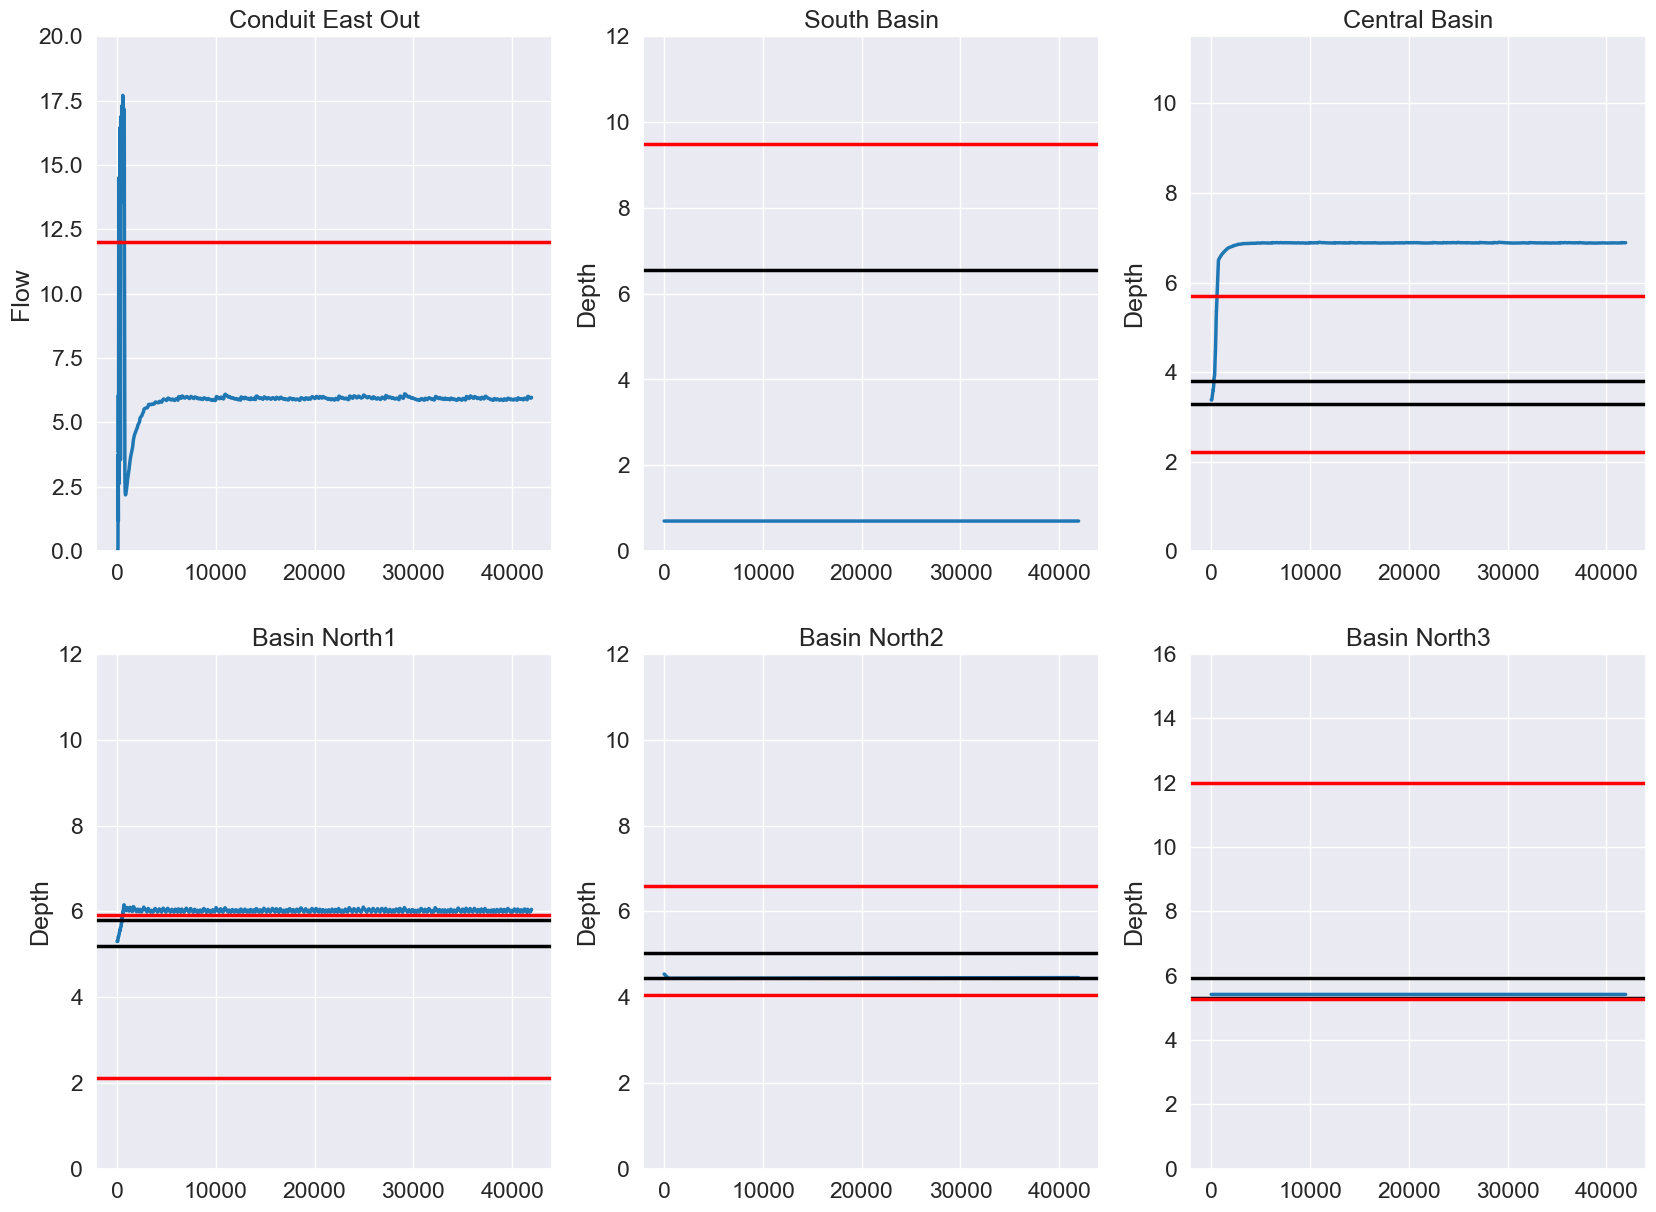

In [18]:
################################################################################
# Plotting
################################################################################

#plotenvironment = env_uncontrolled_zeros
#plotenvironment = env_uncontrolled_ones
plotenvironment = env_equalfilling

plt.subplot(2, 3, 1)
plt.plot(plotenvironment.data_log["flow"]["conduit_Eout"])
plt.axhline(12.0, color="r")
plt.ylim([0,20])
plt.title("Conduit East Out")
plt.ylabel("Flow")

plt.subplot(2, 3, 2)
plt.plot(plotenvironment.data_log["depthN"]["basin_S"])
plt.axhline(9.5, color="r")
plt.axhline(6.55, color="k")
plt.ylim([0,12])
plt.ylabel("Depth")
plt.title("South Basin")

plt.subplot(2, 3, 3)
plt.plot(plotenvironment.data_log["depthN"]["basin_C"])
plt.axhline(5.7, color="r")
plt.axhline(3.8, color="k")
plt.axhline(3.28, color="k")
plt.axhline(2.21, color="r")
plt.ylim([0,11.5])
plt.ylabel("Depth")
plt.title("Central Basin")

plt.subplot(2, 3, 4)
plt.plot(plotenvironment.data_log["depthN"]["basin_N1"])
plt.axhline(5.92, color="r")
plt.axhline(2.11, color="r")
plt.axhline(5.8, color="k")
plt.axhline(5.2, color="k")
plt.ylim([0,12])
plt.ylabel("Depth")
plt.title("Basin North1")

plt.subplot(2, 3, 5)
plt.plot(plotenvironment.data_log["depthN"]["basin_N2"])
plt.axhline(6.59, color="r")
plt.axhline(5.04, color="k")
plt.axhline(4.44, color="k")
plt.axhline(4.04, color="r")
plt.ylim([0,12])
plt.ylabel("Depth")
plt.title("Basin North2")

plt.subplot(2, 3, 6)
plt.plot(plotenvironment.data_log["depthN"]["basin_N3"])
plt.axhline(11.99, color="r")
plt.axhline(5.92, color="k")
plt.axhline(5.32, color="k")
plt.axhline(5.28, color="r")
plt.ylim([0,16])
plt.ylabel("Depth")
plt.title("Basin North3")

plt.show()

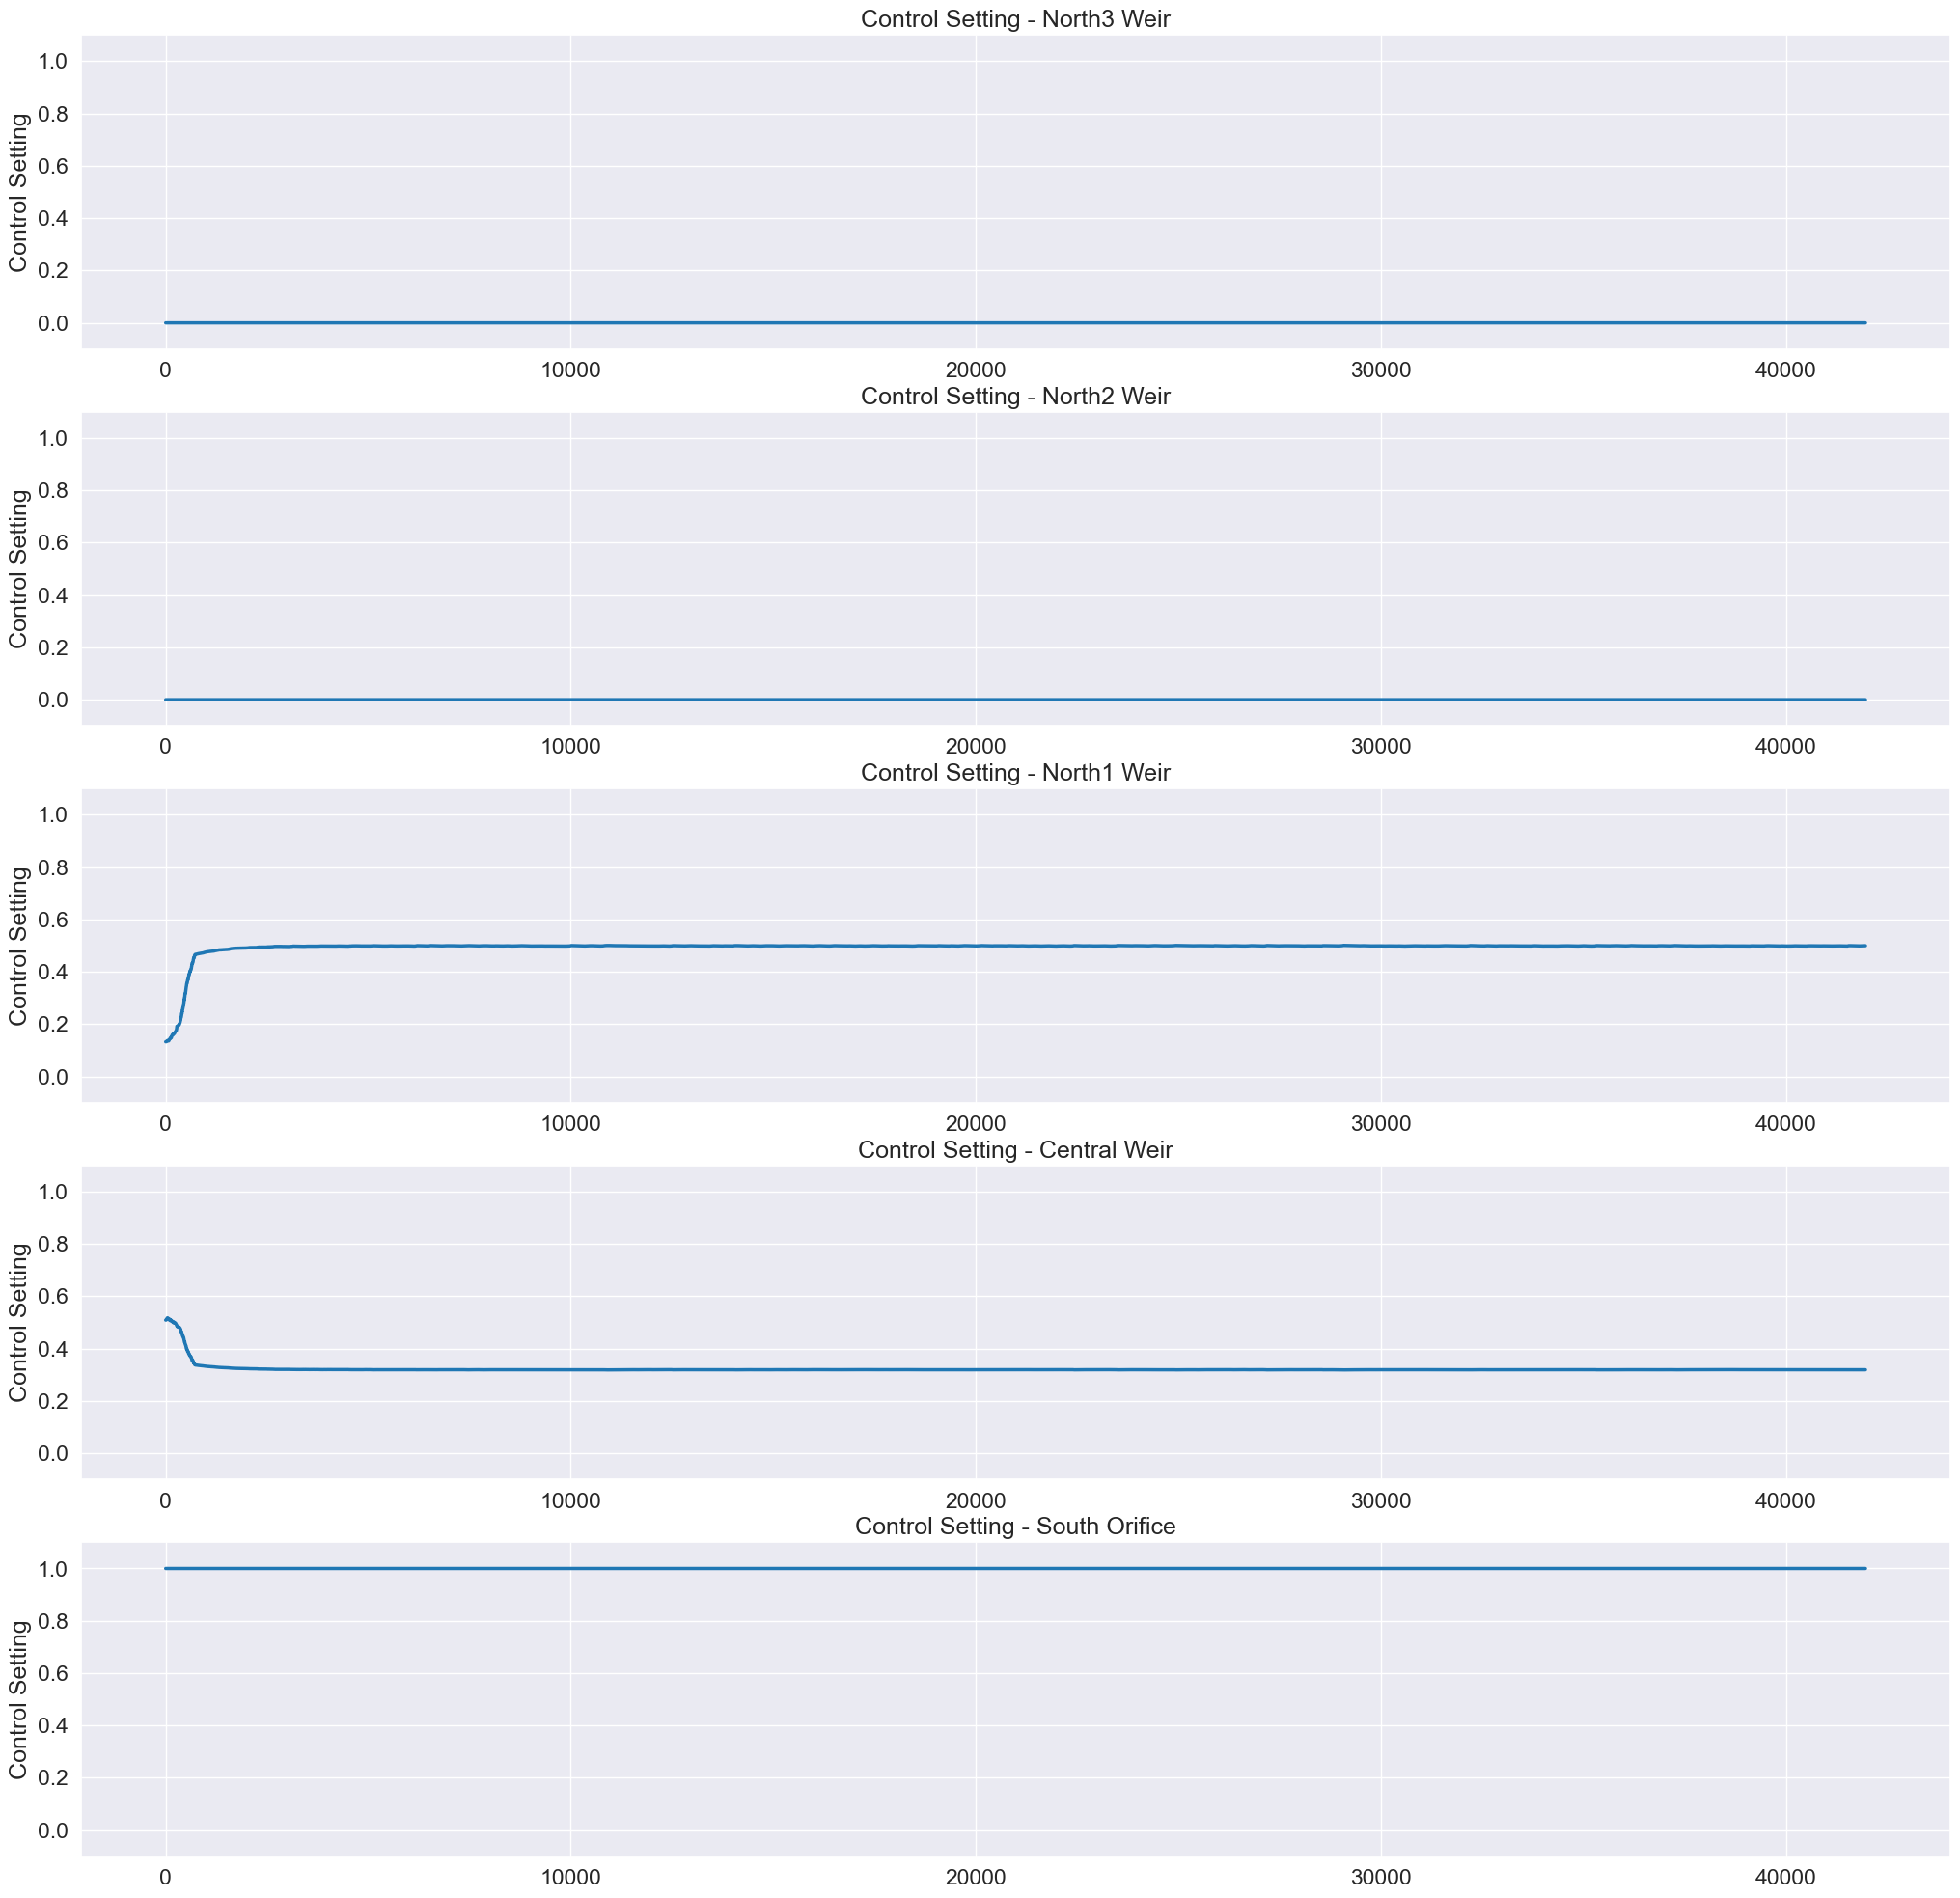

In [25]:
plt.rcParams['figure.figsize'] = [25, 25]

plt.subplot(5, 1, 1)
plt.plot(actions_north3)
plt.ylim([-0.1,1.1])
plt.title("Control Setting - North3 Weir")
plt.ylabel("Control Setting")

plt.subplot(5, 1, 2)
plt.plot(actions_north2)
plt.ylim([-0.1,1.1])
plt.title("Control Setting - North2 Weir")
plt.ylabel("Control Setting")

plt.subplot(5, 1, 3)
plt.plot(actions_north1)
plt.ylim([-0.1,1.1])
plt.title("Control Setting - North1 Weir")
plt.ylabel("Control Setting")

plt.subplot(5, 1, 4)
plt.plot(actions_central)
plt.ylim([-0.1,1.1])
plt.title("Control Setting - Central Weir")
plt.ylabel("Control Setting")

plt.subplot(5, 1, 5)
plt.plot(actions_south)
plt.ylim([-0.1,1.1])
plt.title("Control Setting - South Orifice")
plt.ylabel("Control Setting")

plt.show()